In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [8]:

train_size = 900
test_size = 1000
l2_lambda = 1e-4 


unique_binary_strings = set()
while len(unique_binary_strings) < train_size + test_size:
    binary_string = tuple(np.random.randint(2, size=30))
    unique_binary_strings.add(binary_string)

inputs = np.array(list(unique_binary_strings), dtype=np.float32)
outputs = np.sum(inputs[:, :3], axis=-1) % 2


ones_column = np.ones((inputs.shape[0], 1), dtype=np.float32)
inputs = np.concatenate((inputs, ones_column), axis=1)

indices = np.random.permutation(len(inputs))
split_idx = int(train_size)
X_train, y_train = inputs[indices[:split_idx]], outputs[indices[:split_idx]]
X_eval, y_eval = inputs[indices[split_idx:]], outputs[indices[split_idx:]]


In [9]:

model = Sequential()
model.add(Dense(30, input_dim=31, activation='relu', kernel_regularizer=l2(l2_lambda)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda)))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


class WeightTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_accuracies = []
        self.test_accuracies = []
        self.weights_over_time = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_accuracies.append(logs.get('accuracy'))
        self.test_accuracies.append(logs.get('val_accuracy'))


        weights, biases = self.model.layers[0].get_weights()
        self.weights_over_time.append(weights)


weight_tracking_callback = WeightTrackingCallback()


history = model.fit(X_train, y_train, epochs=500, batch_size=32, 
                    validation_data=(X_eval, y_eval), 
                    callbacks=[weight_tracking_callback])


loss, accuracy = model.evaluate(X_eval, y_eval)
print(f"Test Accuracy: {accuracy * 100:.2f}%")




Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4854 - loss: 0.7373 - val_accuracy: 0.5080 - val_loss: 0.7130
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4634 - loss: 0.7281 - val_accuracy: 0.5090 - val_loss: 0.7084
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5193 - loss: 0.7097 - val_accuracy: 0.5110 - val_loss: 0.7064
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5206 - loss: 0.6894 - val_accuracy: 0.5040 - val_loss: 0.7056
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5023 - loss: 0.6959 - val_accuracy: 0.5090 - val_loss: 0.7036
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5384 - loss: 0.6891 - val_accuracy: 0.5020 - val_loss: 0.7036
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5722 - loss: 0.6803 - val_accuracy: 0.5030 - val_loss: 0.7042
Epoch 8/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5687 - loss: 0.6767 - val_accuracy: 0.5040 - v

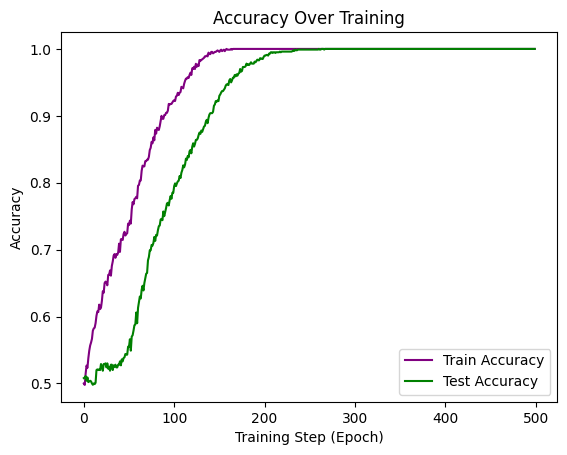

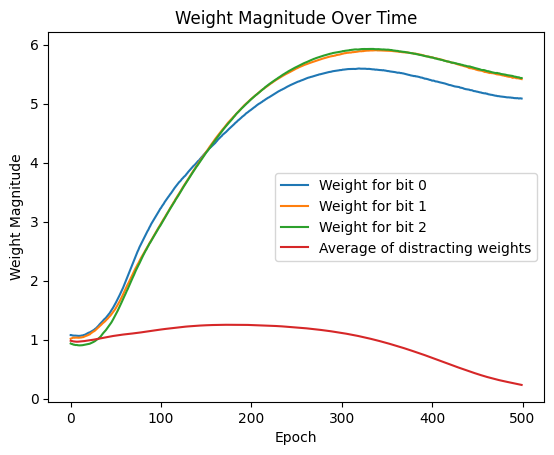

In [10]:

plt.plot(weight_tracking_callback.train_accuracies, label='Train Accuracy', color='purple')
plt.plot(weight_tracking_callback.test_accuracies, label='Test Accuracy', color='green')
plt.title('Accuracy Over Training')
plt.xlabel('Training Step (Epoch)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

weights_over_time = np.array(weight_tracking_callback.weights_over_time)
for i in range(3):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), label=f'Weight for bit {i}')
plt.plot(np.linalg.norm(weights_over_time[:, 3:, :], axis=-1).mean(axis=1), label='Average of distracting weights')
plt.title('Weight Magnitude Over Time')
plt.xlabel('Epoch')
plt.ylabel('Weight Magnitude')
plt.legend()
plt.show()

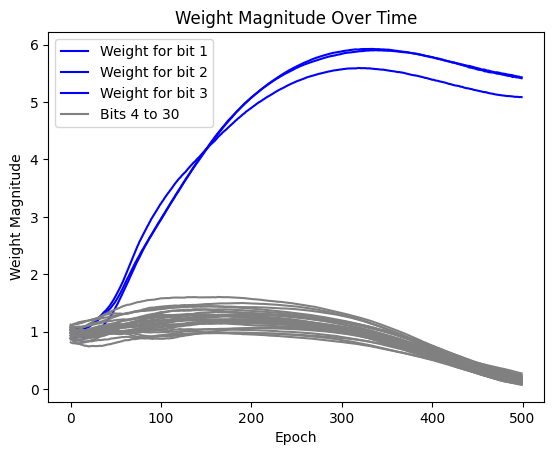

In [11]:
weights_over_time = np.array(weight_tracking_callback.weights_over_time)


for i in range(3):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), label=f'Weight for bit {i+1}', color='blue')


for i in range(3, 30):
    plt.plot(np.linalg.norm(weights_over_time[:, i, :], axis=-1), color='gray')


plt.title('Weight Magnitude Over Time')
plt.xlabel('Epoch')
plt.ylabel('Weight Magnitude')


plt.plot([], [], color='blue')
plt.plot([], [], color='gray', label='Bits 4 to 30')
plt.legend()

plt.show()
